In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.models import load_model
from PIL import Image
from skimage.transform import resize
import os

# Load Model

In [3]:
model = load_model('model2_10200epochs.h5')

# Preprocessing (Resize, Split/Combine Pannels)

In [5]:
PANNEL_SIZE = 224
mu = 0.57417726724528806
std = 0.31263486676782137

def img_resize(img):
    h, w, _ = img.shape
    nvpanels = int(h/PANNEL_SIZE)
    nhpanels = int(w/PANNEL_SIZE)
    new_h, new_w = h, w
    if nvpanels*PANNEL_SIZE != h:
        new_h = (nvpanels+1)*PANNEL_SIZE
    if nhpanels*PANNEL_SIZE != w:
        new_w = (nhpanels+1)*PANNEL_SIZE
    if new_h == h and new_w == w:
        return img
    else:
        result_img = resize(img, output_shape=(new_h, new_w), preserve_range=True)
        result_img = result_img.astype(np.float32) / 255.
        result_img = (result_img - mu) / std
        return result_img

def split_panels(img):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    panels = []
    for i in range(num_vert_panels):
        for j in range(num_hor_panels):
            panels.append(img[i*PANNEL_SIZE:(i+1)*PANNEL_SIZE,j*PANNEL_SIZE:(j+1)*PANNEL_SIZE])
    return np.stack(panels)

def combine_panels(img, panels):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    total = []
    p = 0
    for i in range(num_vert_panels):
        row = []
        for j in range(num_hor_panels):
            row.append(panels[p])
            p += 1
        total.append(np.concatenate(row, axis=1))
    return np.concatenate(total, axis=0)

# Load Test Image

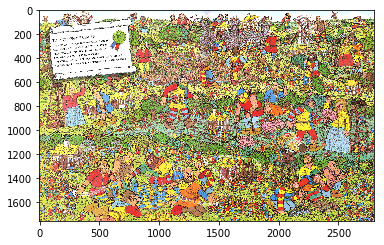

In [121]:
img_filename = '02.jpg'
test_img = np.array(Image.open(os.path.join('test_imgs', img_filename)).resize((2800, 1760), Image.NEAREST))

plt.imshow(test_img)

# Preprocessing

In [122]:
test_img = img_resize(test_img)

panels = split_panels(test_img)

# Prediction

(551, 1159) 100.00%


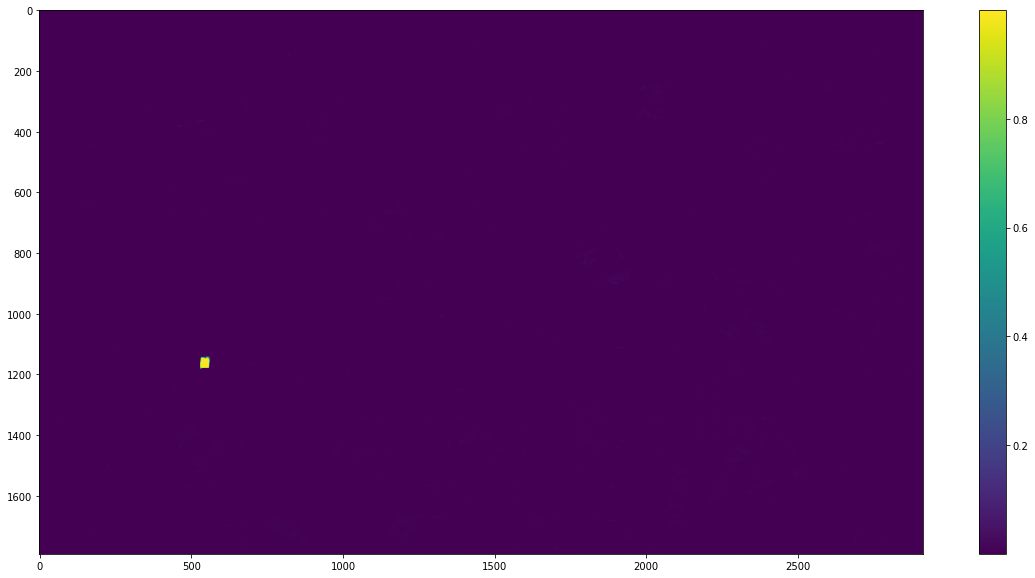

In [123]:
pred_panels = model.predict(panels)

def reshape_pred(pred):
    return pred.reshape((PANNEL_SIZE, PANNEL_SIZE, 2))[:,:,1]

pred_panels = np.stack([reshape_pred(pred) for pred in pred_panels])

pred_out = combine_panels(test_img, pred_panels)

# compute coordinates and confidence
argmax_x = np.argmax(np.max(pred_out, axis=0), axis=0)
argmax_y = np.argmax(np.max(pred_out, axis=1), axis=0)
confidence = np.amax(pred_out) * 100

print('(%s, %s) %.2f%%' % (argmax_x, argmax_y, confidence))

plt.figure(figsize=(20, 10))
plt.imshow(pred_out)
plt.colorbar()

# Overlay Result on Image

532 1144 560 1178


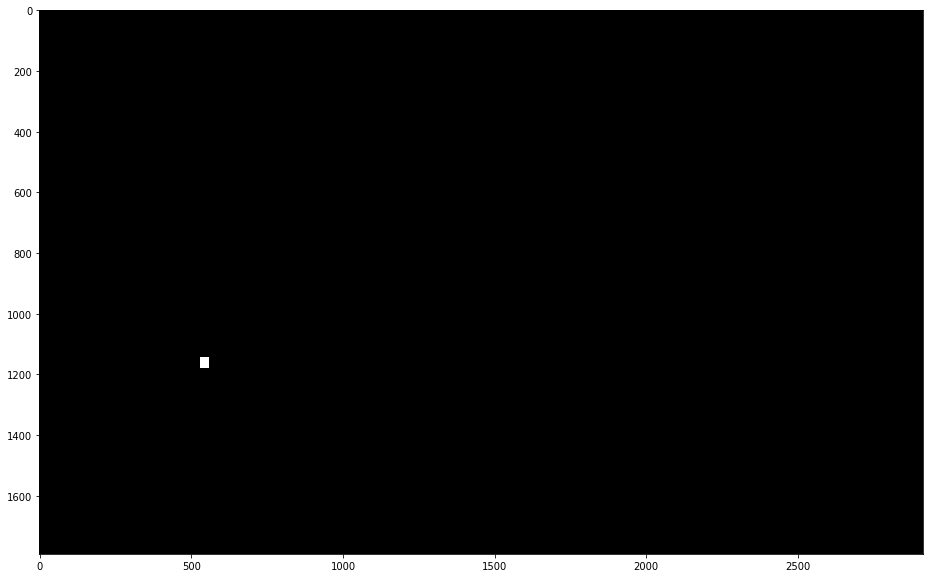

In [124]:
def bbox_from_mask(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return x1, y1, x2, y2

x1, y1, x2, y2 = bbox_from_mask((pred_out > 0.8).astype(np.uint8))
print(x1, y1, x2, y2)

# make overlay
overlay = np.repeat(np.expand_dims(np.zeros_like(pred_out, dtype=np.uint8), axis=-1), 3, axis=-1)
alpha = np.expand_dims(np.full_like(pred_out, 255, dtype=np.uint8), axis=-1)

overlay = np.concatenate([overlay, alpha], axis=-1)

overlay[y1:y2, x1:x2, 3] = 0

plt.figure(figsize=(20, 10))
plt.imshow(overlay)

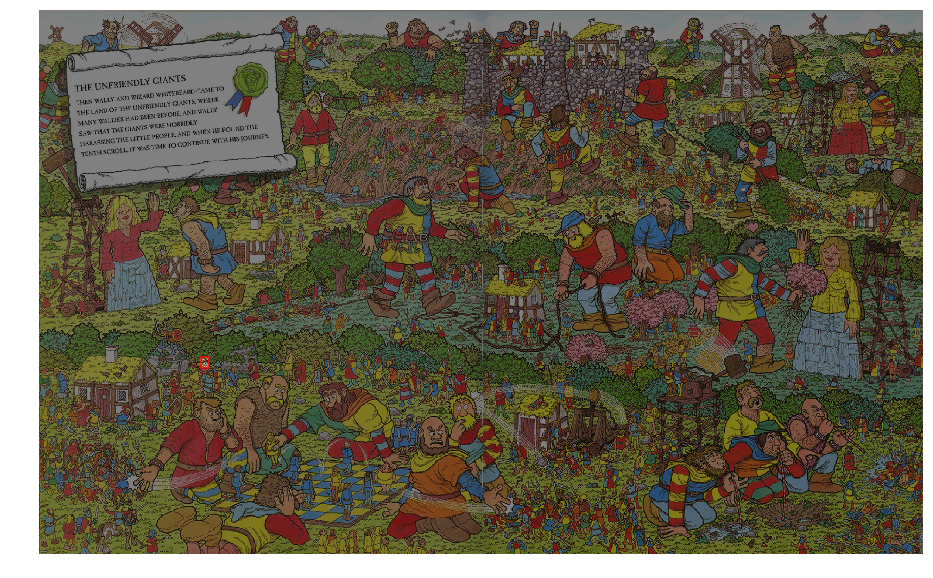

In [125]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(test_img*std+mu)
ax.imshow(overlay, alpha=0.5)

rect = patches.Rectangle((x1, y1), width=x2-x1, height=y2-y1, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.set_axis_off()

fig.savefig(os.path.join('test_result', img_filename), bbox_inches='tight')